# Worflow implementation using Python

## Imports

In [1]:
import pandas
import networkx
from communities.algorithms import girvan_newman
from networkx.algorithms import community
from igraph import Graph

## Reading input data

In [2]:
lfcall = pandas.read_csv("input/lfcall.csv", index_col=0)
exc1 = pandas.read_csv("input/DEGs/exc1.csv", index_col=0)
exc2 = pandas.read_csv("input/DEGs/exc2.csv", index_col=0)
exc3 = pandas.read_csv("input/DEGs/exc3.csv", index_col=0)
exc4e = pandas.read_csv("input/DEGs/exc4e.csv", index_col=0)
exc4s = pandas.read_csv("input/DEGs/exc4s.csv", index_col=0)
sig1 = pandas.read_csv("input/DEGs/sig1.csv", index_col=0)
sig2 = pandas.read_csv("input/DEGs/sig2.csv", index_col=0)
sig3 = pandas.read_csv("input/DEGs/sig3.csv", index_col=0)
sig4e = pandas.read_csv("input/DEGs/sig4e.csv", index_col=0)
sig4s = pandas.read_csv("input/DEGs/sig4s.csv", index_col=0)

In [3]:
yellow_string = pandas.read_csv("input/STRING/yellow_interactions.csv")

In [4]:
yellow_wgcna_genes = pandas.read_csv("input/WGCNA/module_yellow.txt", names=["name"])

In [5]:
dgidb_drugs_yellow = pandas.read_csv("input/DGIDB/dgidb_yellow_interactions.tsv", sep="\t")
dgidb_categories_yellow = pandas.read_csv("input/DGIDB/dgidb_yellow_categories.tsv", sep="\t")

## Processing data

In [6]:
yellow_wgcna = lfcall[lfcall.gene.isin(yellow_wgcna_genes.name)]

In [7]:
yellow_spliting_name = yellow_string.name.str.split(" \\(pp\\) ").str
yellow_string["node1"] = yellow_spliting_name[0]
yellow_string["node2"] = yellow_spliting_name[1]

In [8]:
cols = ["node1", "node2", "experiments", "databases", "score"]
filters = (
    (yellow_string.experiments >= 0.5) | 
    ((yellow_string.experiments >= 0.3) & (yellow_string.databases >= 0.9))
)
filteryellow = yellow_string[cols][filters]

In [9]:
#TODO entender pq precisa renomear e remover itens
filteryellow.loc[filteryellow[filteryellow.node2 == "DP2"].index, "node2"] = "TFDP2"
filteryellow.loc[filteryellow[filteryellow.node2 == "CCL4L1"].index, "node2"] = "CCL4L2"
filteryellow = filteryellow.drop(index=filteryellow[filteryellow.node2 == "ENSP00000412457"].index)

assert filteryellow.node1.isin(yellow_wgcna_genes.name).all()
assert filteryellow.node2.isin(yellow_wgcna_genes.name).all()

## Building Graphs

In [10]:
filteryellow.head()

,node1,node2,experiments,databases,score
111,CX3CL1,CX3CR1,0.379,0.9,0.997
162,CRY1,NPAS2,0.643,0.9,0.996
164,CRY1,QPRT,0.532,NaN,0.549
165,CRY1,ARNTL,0.903,0.9,0.999
194,CD74,HLA-DQA1,0.701,0.9,0.993


In [11]:
gyellow = networkx.from_pandas_edgelist(filteryellow, "node1", "node2", edge_attr=True)

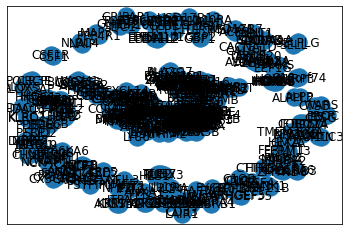

In [12]:
networkx.draw_networkx(gyellow)

### Networkx implementation

In [60]:
comp = community.girvan_newman(gyellow)
subgraphs = []
for c in next(comp):
    if len(c) >= 5:
        print(len(c))
        subgraph = gyellow.subgraph(c).copy()
        subgraph.remove_nodes_from(list(networkx.isolates(subgraph)))
        subgraphs.append(subgraph)

186
7
29
7
17


In [61]:
len(subgraphs)

5

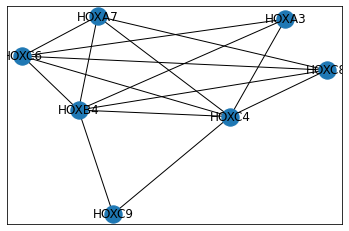

In [62]:
networkx.draw_networkx(subgraphs[1])

### Community implementation

In [28]:
result = girvan_newman(networkx.to_numpy_array(gyellow))
nodes = list(gyellow.nodes)
subgraphs = []
for c in result:
    if len(c) >= 5:
        print(len(c))
        node_names = []
        for n in c:
            node_names.append(nodes[n])
        subgraph = gyellow.subgraph(node_names).copy()
        subgraph.remove_nodes_from(list(networkx.isolates(subgraph)))
        subgraphs.append(subgraph)

11
20
56
7
11
21
21
9
17
29
7
7
6
17
7


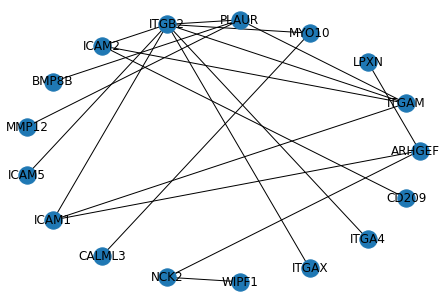

In [29]:
networkx.draw_circular(subgraphs[8], with_labels=True)

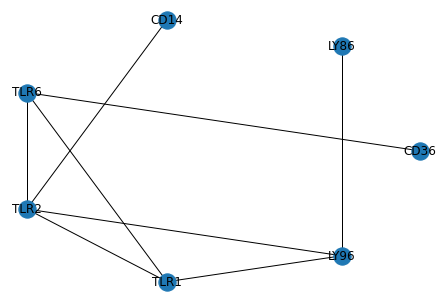

In [30]:
networkx.draw_circular(subgraphs[14], with_labels=True)

- 0 = 3
- 1 = 4
- 2 = 7
- 3 = 12
- 4 = 10
- 5 = 11
- 6 = 8
- 7 = 13
- 8 = subgraph 5
- 9 = 1
- 10 = 2
- 11 = 14
- 12 = 9
- 13 = 6
- 14 = subgraph 5

subgraph 5 between ITGB2 and CD14

### IGraph implementation

In [32]:
igyellow = Graph.from_networkx(gyellow)

In [33]:
communities = igyellow.community_edge_betweenness(directed=False)

In [35]:
def fix_dendrogram(graph, cl):
    already_merged = set()
    for merge in cl.merges:
        already_merged.update(merge)

    num_dendrogram_nodes = graph.vcount() + len(cl.merges)
    not_merged_yet = sorted(set(range(num_dendrogram_nodes)) - already_merged)
    if len(not_merged_yet) < 2:
        return

    v1, v2 = not_merged_yet[:2]
    cl._merges.append((v1, v2))
    del not_merged_yet[:2]

    missing_nodes = range(num_dendrogram_nodes,
            num_dendrogram_nodes + len(not_merged_yet))
    cl._merges.extend(zip(not_merged_yet, missing_nodes))
    cl._nmerges = graph.vcount()-1



In [36]:
fix_dendrogram(igyellow, communities)

In [37]:
clusteres = communities.as_clustering()

In [54]:
subgraphs = []
nodes = list(gyellow.nodes)
for c in clusteres:
    if len(c) >= 5:
        print(len(c))
        node_names = []
        for n in c:
            node_names.append(nodes[n])
        subgraph = gyellow.subgraph(node_names).copy()
        subgraph.remove_nodes_from(list(networkx.isolates(subgraph)))
        subgraphs.append(subgraph)

153
215
7
7
17


In [55]:
len(subgraphs)

5

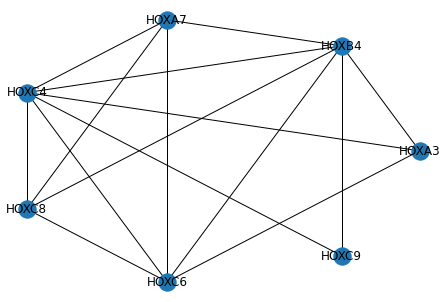

In [59]:
networkx.draw_circular(subgraphs[2], with_labels=True)